生成二分类样例数据：

In [1]:
from sklearn.datasets import make_classification

X, y = make_classification(n_features = 2, n_informative = 2, n_redundant = 0, n_samples = 100, n_classes = 2, random_state = 0)
y[y == 0] = -1

In [2]:
import numpy as np

def distance(X, b, p = 2):
        """
        计算距离

        参数
        ----------
        X : 特征矩阵

        b : 特征向量
        
        p : 距离范数，默认为 2，即欧式距离
        """
        
        return np.linalg.norm(X - b, ord = p, axis = 1)

k-d 树实现：

In [3]:
class kdnode:
    """
    k-d 树结点
    """
    
    def __init__(self, feature, value, index, left = None, right = None):
        # 结点对应特征的维度下标
        self.feature = feature
        # 结点对应训练集的特征值；当结点为叶子结点时，为特征向量
        self.value = value
        # 结点对应训练集的下标；当结点为叶子结点时，为下标向量
        self.index = index
        # 左子树
        self.left = left
        # 右子树
        self.right = right

class kdtree:
    """
    k-d 树算法实现
    
    参数
    ----------
    X : 特征矩阵

    leaf_size : 叶子节点包含的最大特征矩阵数量，默认为 10
    """
    
    def __init__(self, X, leaf_size = 10):
        def build_node(X, X_indexes, depth, leaf_size):
            """
            构建结点
            
            参数
            ----------
            X : 特征矩阵

            X_indexes : 特征矩阵下标
            
            depth : 深度
            
            leaf_size : 叶子节点包含的最大特征矩阵数量
            """
            
            # 当前特征的维度下标
            feature = np.mod(depth, X.shape[1])
            # 当前特征矩阵的大小小于等于指定的叶子结点包含的特征矩阵数量时构建叶子结点并返回
            if X.shape[0] <= leaf_size:
                return kdnode(feature, X, X_indexes)
            # 当前特征维度下的特征向量
            X_feature = X[:, feature]
            # 按照当前特征维度排序后的下标向量
            X_sort_indexes = np.argsort(X_feature)
            # 按照当前特征维度排序后的特征矩阵
            X_sort = X[X_sort_indexes]
            # 中间下标
            median = X.shape[0] // 2
            # 左边的特征矩阵
            X_left = X_sort[:median]
            # 左边的特征矩阵对应排序后的下标
            X_left_index = X_indexes[X_sort_indexes[:median]]
            # 递归的构建左子树
            left = build_node(X_left, X_left_index, depth + 1, leaf_size)
            # 右边的特征矩阵
            X_right = X_sort[median + 1:]
            # 右边的特征矩阵对应排序后的下标
            X_right_index = X_indexes[X_sort_indexes[median + 1:]]
            # 递归的构建右子树
            right = build_node(X_right, X_right_index, depth + 1, leaf_size)
            # 构建当前结点并返回
            return kdnode(feature, X_sort[median], X_indexes[X_sort_indexes[median]], left, right)
        # 根结点
        self.root = build_node(X, np.array(range(X.shape[0])), 0, leaf_size)
        
    def query(self, X, k = 1, p = 2):
        """
        查询距离最近 k 个特征向量

        参数
        ----------
        X : 特征矩阵

        k : 最近邻的数量，默认为 1
        
        p : 距离范数，默认为 2，即欧式距离
        """
        
        # 最近邻对应的下标向量
        nearests = -np.ones((len(X), k), dtype = np.int8)
        # 最近邻对应的距离向量
        distances = -np.ones((len(X), k))
        return self.search(X, self.root, nearests, distances, p)
    
    def search(self, X, node, nearests, distances, p = 2):
        """
        搜索距离最近 k 个特征向量
        """
        
        # 当前结点不是叶子结点时
        if node.left is not None or node.right is not None:
            # 当前特征下的特征值与切分值之差
            axis = X[:, node.feature] - node.value[node.feature]
            # 切分点左边
            axis_left = axis < 0
            if (axis_left).any():
                # 递归的搜索左子树
                nearests[axis_left, :], distances[axis_left, :] = self.search(X[axis_left, :], node.left, nearests[axis_left, :], distances[axis_left, :], p)
            # 切分点右边
            axis_right = ~axis_left
            if (axis_right).any():
                # 递归的搜索右子树
                nearests[axis_right, :], distances[axis_right, :] = self.search(X[axis_right, :], node.right, nearests[axis_right, :], distances[axis_right, :], p)
            # 计算距离
            dist = distance(X, node.value, p)
            # 是否所有特征点都处理过
            all_cond = np.zeros((X.shape[0],), dtype=np.bool)
            # 依次遍历 k 次
            for i in range(nearests.shape[1]):
                # 当前记录的距离为-1或者新的距离小于当前记录的距离
                cond = (~all_cond) & ((distances[:, i] < 0) | (dist - distances[:, i] < 0))
                # 没有满足条件的特征点就跳过
                if (~cond).all():
                    continue
                # 插入最新的下标值
                ns = np.insert(nearests[cond, :], i, node.index, axis=1)
                nearests[cond, :] = ns[:,:-1]
                # 插入最新的距离
                ds = np.insert(distances[cond, :], i, dist[cond], axis=1)
                distances[cond, :] = ds[:,:-1]
                # 更新判断条件
                all_cond = all_cond | cond
                # 所有特征点都处理过则跳出
                if all_cond.all():
                    break
            # 距离记录中最大的距离大于切分轴（即另一边的子树可能包含更近的邻居）
            over = np.max(distances, axis=1) - np.abs(axis) > 0
            if over.any():
                # 递归的搜索右子树
                over_left = over & axis_left
                if (over_left).any():
                    nearests[over_left, :], distances[over_left, :] = self.search(X[over_left, :], node.right, nearests[over_left, :], distances[over_left, :], p)
                # 递归的搜索左子树
                over_right = over & axis_right
                if (over_right).any():
                    nearests[over_right, :], distances[over_right, :] = self.search(X[over_right, :], node.left, nearests[over_right, :], distances[over_right, :], p)
        else:
            # 依次遍历当前叶子结点包含的特征向量
            for i in range(len(node.value)):
                # 更新下标与距离记录的方式同上
                dist = distance(X, node.value[i], p)
                all_cond = np.zeros((X.shape[0],), dtype=np.bool)
                for j in range(nearests.shape[1]):
                    cond = (~all_cond) & ((distances[:, j] < 0) | (dist - distances[:, j] < 0))
                    if (~cond).all():
                        continue
                    ns = np.insert(nearests[cond, :], j, node.index[i], axis=1)
                    nearests[cond, :] = ns[:,:-1]
                    ds = np.insert(distances[cond, :], j, dist[cond], axis=1)
                    distances[cond, :] = ds[:,:-1]
                    all_cond = all_cond | cond
                    if all_cond.all():
                        break
        return nearests, distances

Ball 树实现：

In [4]:
class ballnode:
    """
    ball 树结点
    """
    
    def __init__(self, value, index, radius, left = None, right = None):
        # 结点对应训练集的特征值；当结点为叶子结点时，为特征向量
        self.value = value
        # 结点对应训练集的下标；当结点为叶子结点时，为下标向量
        self.index = index
        # 超球体的半径
        self.radius = radius
        # 左子树
        self.left = left
        # 右子树
        self.right = right

class balltree:
    """
    ball 树算法实现
    
    参数
    ----------
    X : 特征矩阵

    leaf_size : 叶子节点包含的最大特征矩阵数量，默认为 10
    
    p : 距离范数，默认为 2，即欧式距离
    """
    
    def __init__(self, X, leaf_size = 10, p = 2):
        def build_node(X, X_indexes, leaf_size):
            """
            构建结点
            
            参数
            ----------
            X : 特征矩阵

            X_indexes : 特征矩阵下标
            
            leaf_size : 叶子节点包含的最大特征矩阵数量
            """
            
            # 当前特征矩阵的大小小于等于指定的叶子结点包含的特征矩阵数量时构建叶子结点并返回
            if X.shape[0] <= leaf_size:
                return ballnode(X, X_indexes, None)
            # 距离最宽的维度（标准差越大，代表该维度下样本点之间差距有大）
            feature = np.argmax(np.std(X, axis=0))
            # 该维度下最大的样本点
            X_feature_max = X[np.argmin(X[:, feature])]
            # 该维度下最小的样本点
            X_feature_min = X[np.argmax(X[:, feature])]
            # 中心点
            X_feature_median = (X_feature_max + X_feature_min) / 2
            # 每个样本点与中心点之间的最大距离
            radius = np.max(distance(X, X_feature_median, p))
            # 将样本点分成两类
            left_index = (distance(X, X_feature_max, p) - distance(X, X_feature_min, p)) < 0
            if left_index.any():
                # 递归的构建左子树
                left = build_node(X[left_index, :], X_indexes[left_index], leaf_size)
            right_index = ~left_index
            if right_index.any():
                # 递归的构建右子树
                right = build_node(X[right_index, :], X_indexes[right_index], leaf_size)
            # 构建当前结点并返回
            return ballnode(X_feature_median, None, radius, left, right)
        # 根结点
        self.root = build_node(X, np.array(range(X.shape[0])), leaf_size)
        
    def query(self, X, k = 1, p = 2):
        """
        查询距离最近 k 个特征向量

        参数
        ----------
        X : 特征矩阵

        k : 最近邻的数量，默认为 1
        
        p : 距离范数，默认为 2，即欧式距离
        """
        
        # 最近邻对应的下标向量
        nearests = -np.ones((len(X), k), dtype = np.int8)
        # 最近邻对应的距离向量
        distances = -np.ones((len(X), k))
        return self.search(X, self.root, nearests, distances, p)
    
    def search(self, X, node, nearests, distances, p = 2):
        """
        搜索距离最近 k 个特征向量
        """
        
        # 当前结点不是叶子结点时
        if node.left is not None or node.right is not None:
            # 最大的距离
            max_distance = np.max(distances, axis=1)
            # 样本点与当前结点对应的超球面最近的距离大于当前的最大距离时，其子结点不可能存在跟近的距离，直接跳过
            over = ((distance(X, node.value, p) - node.radius - max_distance) >= 0) & (distances != -1).all()
            if over.all():
                return nearests, distances
            unover = ~over
            # 递归搜索左子数
            nearests[unover, :], distances[unover, :] = self.search(X[unover, :], node.left, nearests[unover, :], distances[unover, :], p)
            # 递归搜索右子数
            nearests[unover, :], distances[unover, :] = self.search(X[unover, :], node.right, nearests[unover, :], distances[unover, :], p)
        else:
            # 依次遍历当前叶子结点包含的特征向量
            for i in range(len(node.value)):
                # 更新下标与距离记录的方式 k-d 树
                dist = distance(X, node.value[i], p)
                all_cond = np.zeros((X.shape[0],), dtype=np.bool)
                for j in range(nearests.shape[1]):
                    cond = (~all_cond) & ((distances[:, j] < 0) | (dist - distances[:, j] < 0))
                    if (~cond).all():
                        continue
                    ns = np.insert(nearests[cond, :], j, node.index[i], axis=1)
                    nearests[cond, :] = ns[:,:-1]
                    ds = np.insert(distances[cond, :], j, dist[cond], axis=1)
                    distances[cond, :] = ds[:,:-1]
                    all_cond = all_cond | cond
                    if all_cond.all():
                        break
        return nearests, distances

k近邻分类实现：

In [5]:
class knnc:
    """
    k近邻分类器（使用 k-d 树和 Ball 树实现）

    参数
    ----------
    k : 最近邻的数量，默认为 5

    leaf_size : 叶子节点包含的最大特征矩阵数量，默认为 10

    p : 距离范数，默认为 2，即欧式距离
    """
    
    def __init__(self, k = 5, leaf_size = 10, p = 2, tree = "kdtree"):
        self.k = k
        self.leaf_size = leaf_size
        self.p = p
        self.tree = tree
        
    def fit(self, X, y):
        """
        k近邻分类拟合

        参数
        ----------
        X : 特征矩阵

        y : 标签分类
        """
        
        if self.tree == "kdtree":
            self._tree = kdtree(X, leaf_size = self.leaf_size)
        else:
            self._tree = balltree(X, leaf_size = self.leaf_size, p = self.p)
        self.y = np.array(y)
        self.y_classes = np.unique(y)
    
    def predict(self, X):
        """
        k近邻分类预测

        参数
        ----------
        X : 特征矩阵
        """
        
        nearests, distances = self._tree.query(X, k = self.k, p = self.p)
        predict_y = self.y[nearests]
        predict_y_count = np.zeros((len(predict_y), len(self.y_classes)), dtype=np.int8)
        for i, y_class in enumerate(self.y_classes):
            predict_y_count[:, i] = np.sum(predict_y == y_class, axis=1)
        return self.y_classes[np.argmax(predict_y_count, axis=1)]

k近邻分类拟合：

In [6]:
clf = knnc()
clf.fit(X, y)

k近邻分类可视化：

<IPython.core.display.Javascript object>


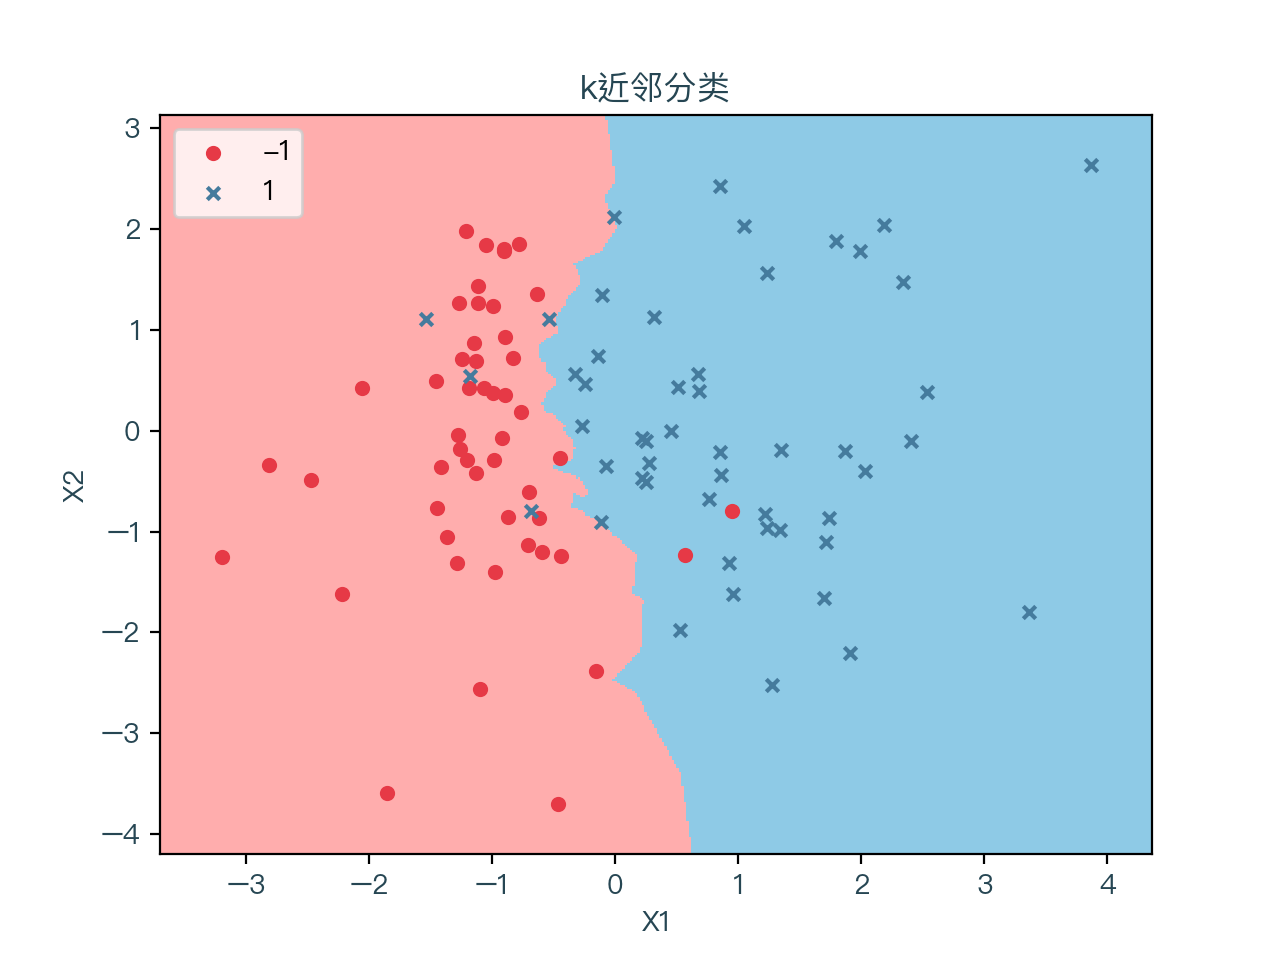

/Users/saisimon/opt/anaconda3/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

%matplotlib notebook

plt.rcParams['font.sans-serif'] = ['PingFang HK']  # 选择一个本地的支持中文的字体
fig, ax = plt.subplots()
ax.set_facecolor('#f8f9fa')

x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, .02), np.arange(y_min, y_max, .02))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
clist=['#ffadad', '#8ecae6']
newcmp = LinearSegmentedColormap.from_list('point_color', clist)
plt.pcolormesh(xx, yy, Z, cmap = newcmp)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

x1 = X[y==-1][:, 0]
y1 = X[y==-1][:, 1]
x2 = X[y==1][:, 0]
y2 = X[y==1][:, 1]
p1 = plt.scatter(x1, y1, c='#e63946', marker='o', s=20)
p2 = plt.scatter(x2, y2, c='#457b9d', marker='x', s=20)

ax.set_title('k近邻分类', color='#264653')
ax.set_xlabel('X1', color='#264653')
ax.set_ylabel('X2', color='#264653')
ax.tick_params(labelcolor='#264653')
plt.legend([p1, p2], ["-1", "1"], loc="upper left")
plt.show()

k近邻分类（scikit-learn）：

In [8]:
from sklearn.neighbors import KNeighborsClassifier

# k近邻分类器
clf = KNeighborsClassifier(n_neighbors = 5)
# 拟合数据集
clf = clf.fit(X, y)

k近邻分类可视化（scikit-learn）：

<IPython.core.display.Javascript object>


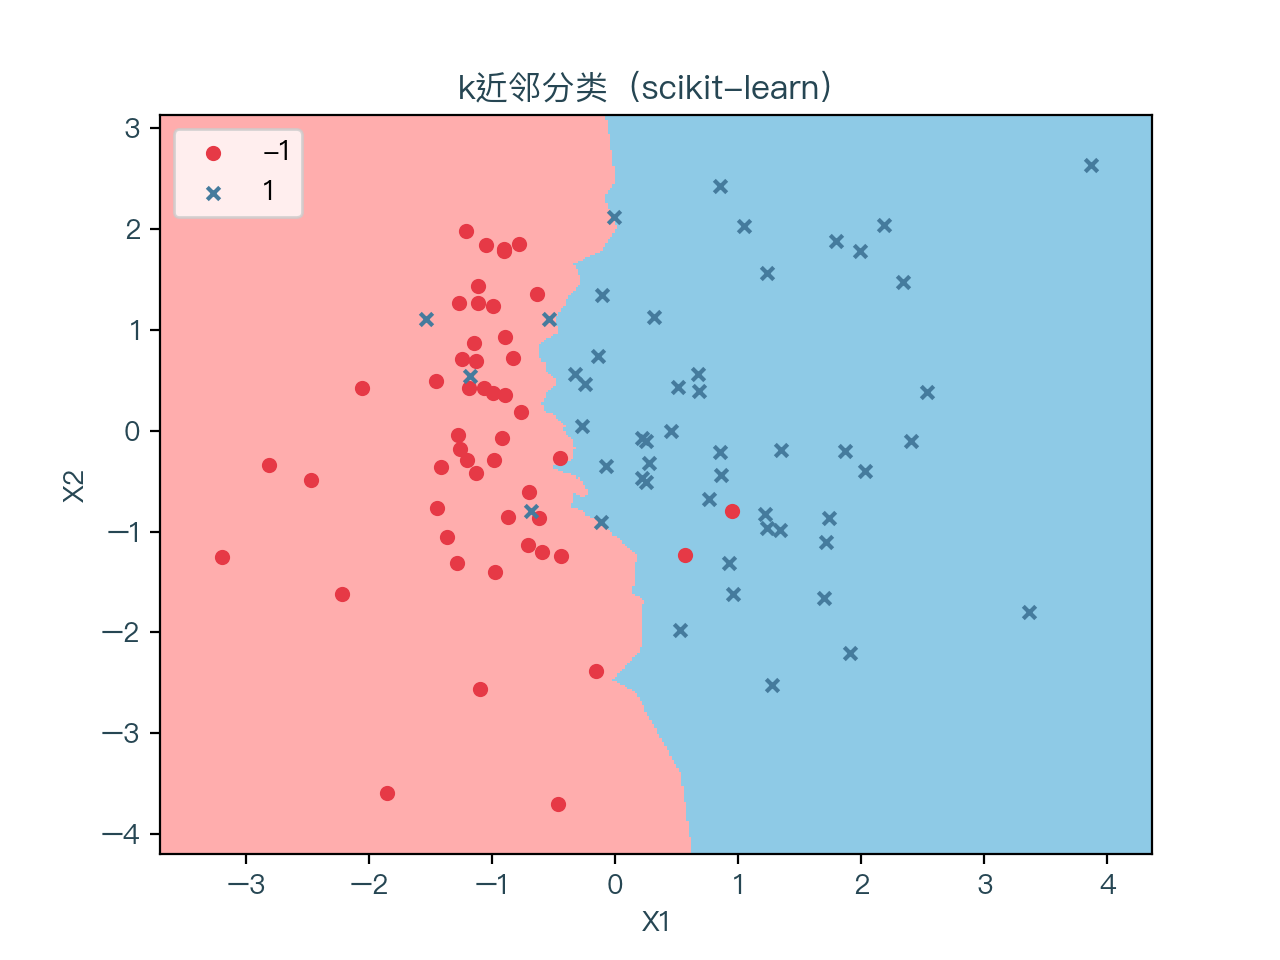

/Users/saisimon/opt/anaconda3/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


In [9]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

%matplotlib notebook

plt.rcParams['font.sans-serif'] = ['PingFang HK']  # 选择一个本地的支持中文的字体
fig, ax = plt.subplots()
ax.set_facecolor('#f8f9fa')

x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, .02), np.arange(y_min, y_max, .02))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
clist=['#ffadad', '#8ecae6']
newcmp = LinearSegmentedColormap.from_list('point_color', clist)
plt.pcolormesh(xx, yy, Z, cmap = newcmp)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

x1 = X[y==-1][:, 0]
y1 = X[y==-1][:, 1]
x2 = X[y==1][:, 0]
y2 = X[y==1][:, 1]
p1 = plt.scatter(x1, y1, c='#e63946', marker='o', s=20)
p2 = plt.scatter(x2, y2, c='#457b9d', marker='x', s=20)

ax.set_title('k近邻分类（scikit-learn）', color='#264653')
ax.set_xlabel('X1', color='#264653')
ax.set_ylabel('X2', color='#264653')
ax.tick_params(labelcolor='#264653')
plt.legend([p1, p2], ["-1", "1"], loc="upper left")
plt.show()

生成多分类样例数据：

In [10]:
import numpy as np
from sklearn.datasets import make_classification

X, y = make_classification(n_features = 2, n_informative = 2, n_redundant = 0, n_samples = 100, n_classes = 3, n_clusters_per_class = 1, random_state = 0)

k近邻多分类拟合：

In [11]:
clf = knnc(tree = "balltree")
clf.fit(X, y)

k近邻多分类可视化：

<IPython.core.display.Javascript object>


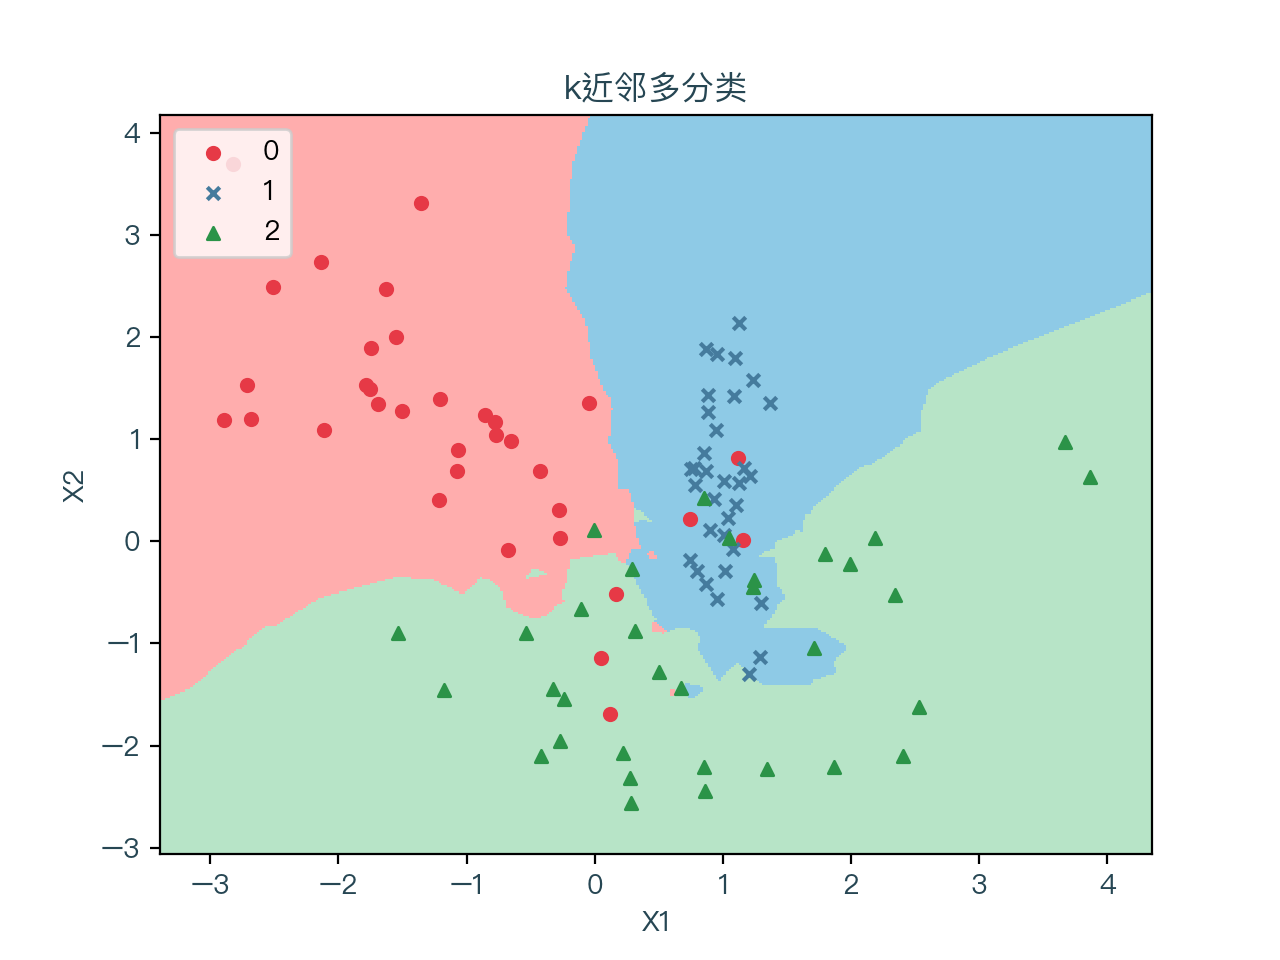

/Users/saisimon/opt/anaconda3/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


In [12]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

%matplotlib notebook

plt.rcParams['font.sans-serif'] = ['PingFang HK']  # 选择一个本地的支持中文的字体
fig, ax = plt.subplots()
ax.set_facecolor('#f8f9fa')

x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, .02), np.arange(y_min, y_max, .02))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
clist=['#ffadad', '#8ecae6', "#b7e4c7"]
newcmp = LinearSegmentedColormap.from_list('point_color', clist)
plt.pcolormesh(xx, yy, Z, cmap = newcmp)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

x1 = X[y==0][:, 0]
y1 = X[y==0][:, 1]
x2 = X[y==1][:, 0]
y2 = X[y==1][:, 1]
x3 = X[y==2][:, 0]
y3 = X[y==2][:, 1]
p1 = plt.scatter(x1, y1, c='#e63946', marker='o', s=20)
p2 = plt.scatter(x2, y2, c='#457b9d', marker='x', s=20)
p3 = plt.scatter(x3, y3, c='#2b9348', marker='^', s=20)

ax.set_title('k近邻多分类', color='#264653')
ax.set_xlabel('X1', color='#264653')
ax.set_ylabel('X2', color='#264653')
ax.tick_params(labelcolor='#264653')
plt.legend([p1, p2, p3], ["0", "1", "2"], loc="upper left")
plt.show()

k近邻多分类（scikit-learn）：

In [13]:
from sklearn.neighbors import KNeighborsClassifier

# k近邻分类器
clf = KNeighborsClassifier(n_neighbors = 5)
# 拟合数据集
clf = clf.fit(X, y)

k近邻多分类可视化（scikit-learn）：

<IPython.core.display.Javascript object>


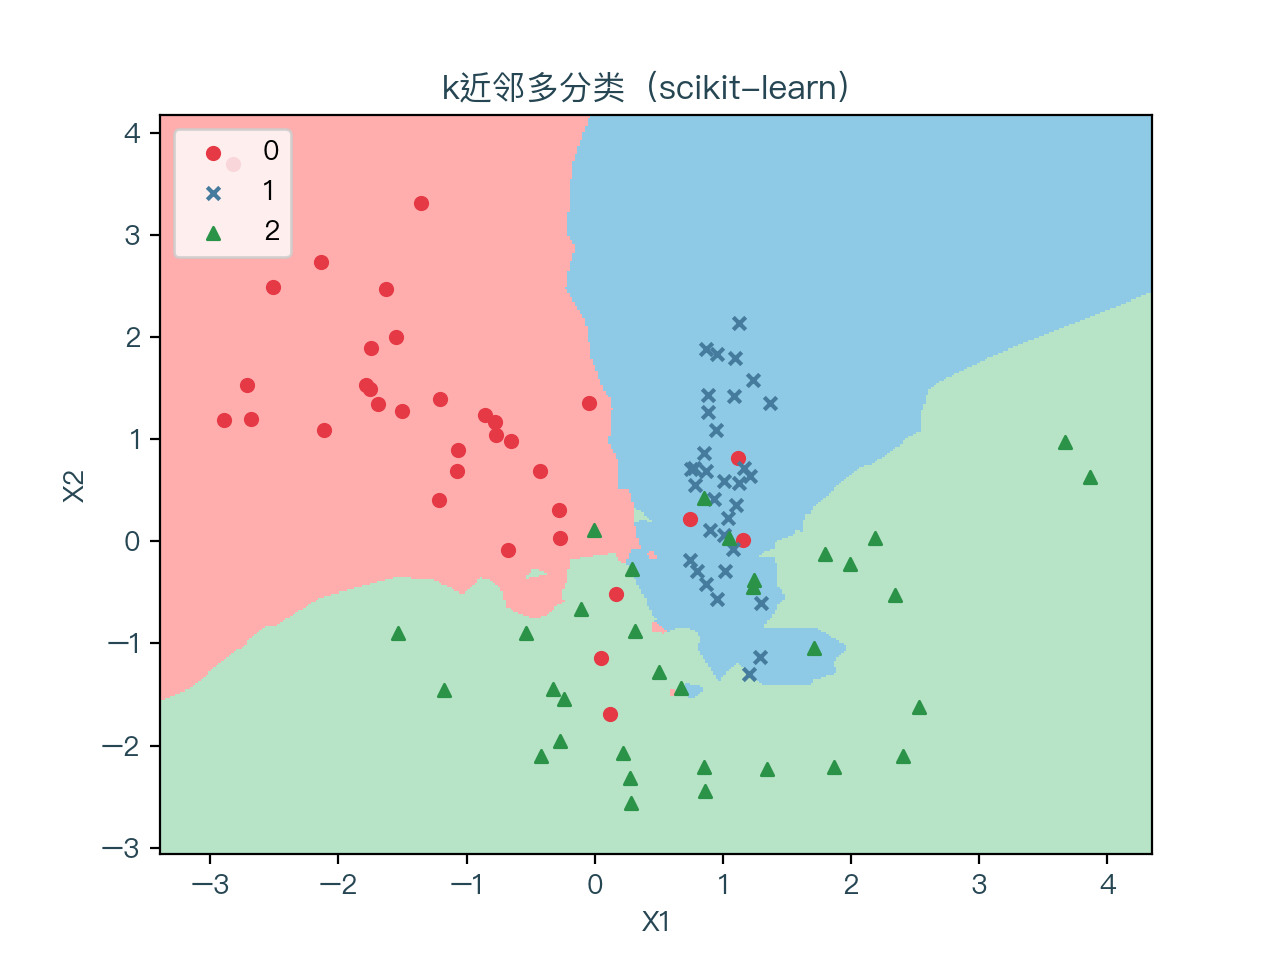

/Users/saisimon/opt/anaconda3/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


In [14]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

%matplotlib notebook

plt.rcParams['font.sans-serif'] = ['PingFang HK']  # 选择一个本地的支持中文的字体
fig, ax = plt.subplots()
ax.set_facecolor('#f8f9fa')

x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, .02), np.arange(y_min, y_max, .02))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
clist=['#ffadad', '#8ecae6', "#b7e4c7"]
newcmp = LinearSegmentedColormap.from_list('point_color', clist)
plt.pcolormesh(xx, yy, Z, cmap = newcmp)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

x1 = X[y==0][:, 0]
y1 = X[y==0][:, 1]
x2 = X[y==1][:, 0]
y2 = X[y==1][:, 1]
x3 = X[y==2][:, 0]
y3 = X[y==2][:, 1]
p1 = plt.scatter(x1, y1, c='#e63946', marker='o', s=20)
p2 = plt.scatter(x2, y2, c='#457b9d', marker='x', s=20)
p3 = plt.scatter(x3, y3, c='#2b9348', marker='^', s=20)

ax.set_title('k近邻多分类（scikit-learn）', color='#264653')
ax.set_xlabel('X1', color='#264653')
ax.set_ylabel('X2', color='#264653')
ax.tick_params(labelcolor='#264653')
plt.legend([p1, p2, p3], ["0", "1", "2"], loc="upper left")
plt.show()

生成回归样例数据：

In [15]:
from sklearn.datasets import make_regression

X, y = make_regression(n_features = 1, n_targets = 1, n_samples = 100, noise = 5, random_state = 0)

k近邻回归实现：

In [16]:
class knnr:
    """
    k近邻回归器（使用 k-d 树和 Ball 树实现）

    参数
    ----------
    k : 最近邻的数量，默认为 5

    leaf_size : 叶子节点包含的最大特征矩阵数量，默认为 10

    p : 距离函数参数，默认为 2，即欧式距离
    """
    def __init__(self, k = 5, leaf_size = 10, p = 2, tree = "kdtree"):
        self.k = k
        self.leaf_size = leaf_size
        self.p = p
        self.tree = tree
        
    def fit(self, X, y):
        """
        k近邻回归拟合

        参数
        ----------
        X : 特征矩阵

        y : 标签分类
        """
        
        if self.tree == "kdtree":
            self._tree = kdtree(X, leaf_size = self.leaf_size)
        else:
            self._tree = balltree(X, leaf_size = self.leaf_size, p = self.p)
        self.y = np.array(y)
    
    def predict(self, X):
        """
        k近邻回归预测

        参数
        ----------
        X : 特征矩阵
        """
        
        nearests, distances = self._tree.query(X, k = self.k, p = self.p)
        predict_y = self.y[nearests]
        return np.average(predict_y, axis=1)

k近邻回归拟合：

In [17]:
reg = knnr()
reg.fit(X, y)

k近邻回归可视化：

<IPython.core.display.Javascript object>


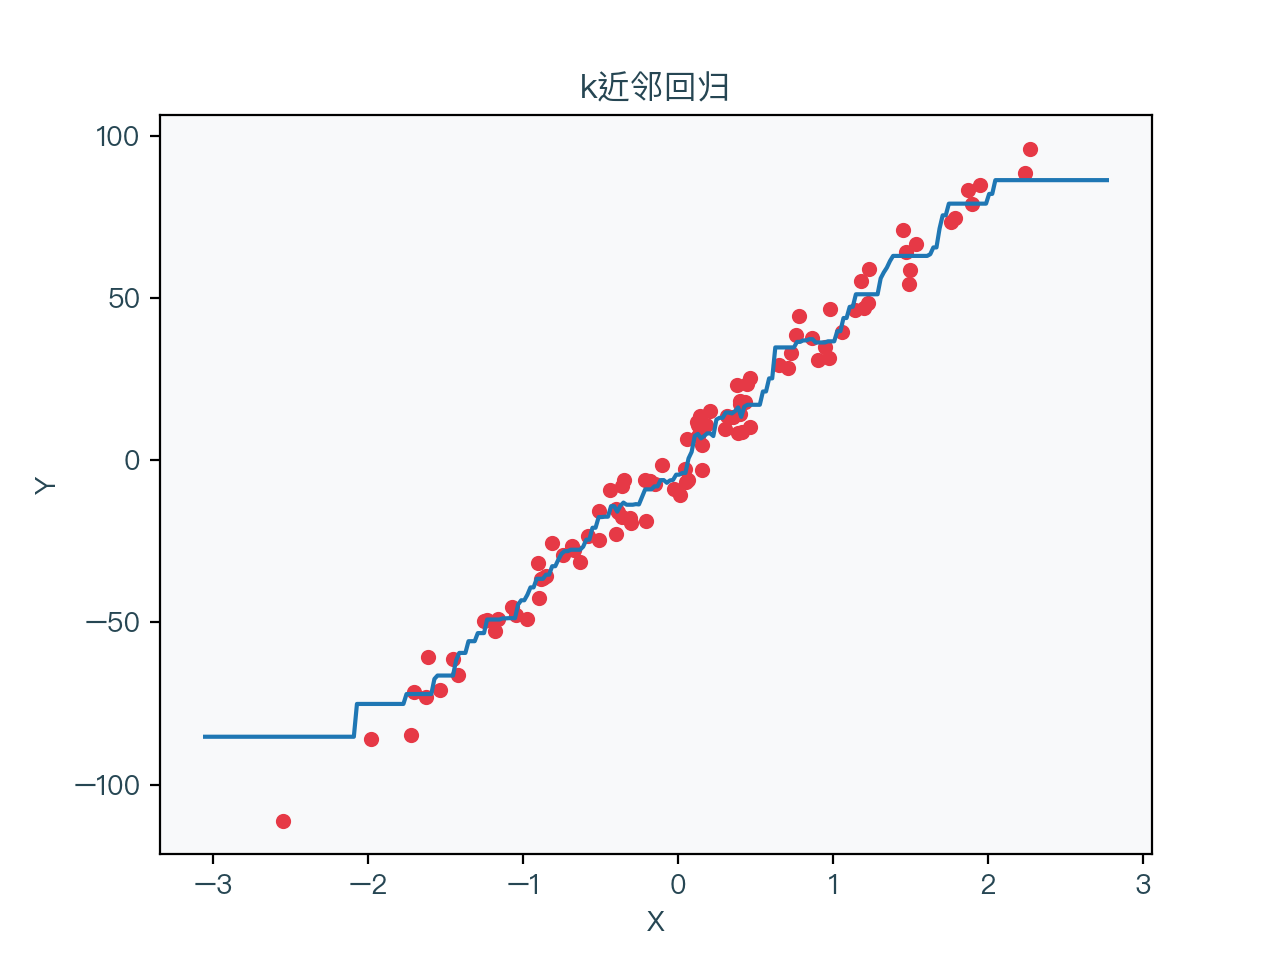

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

%matplotlib notebook

plt.rcParams['font.sans-serif'] = ['PingFang HK']  # 选择一个本地的支持中文的字体
fig, ax = plt.subplots()
ax.set_facecolor('#f8f9fa')

x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
xx = np.arange(x_min, x_max, .02)
yy = reg.predict(np.c_[xx.ravel()])

plt.scatter(X, y, c='#e63946', marker='o', s=20)
plt.plot(xx, yy)

ax.set_title('k近邻回归', color='#264653')
ax.set_xlabel('X', color='#264653')
ax.set_ylabel('Y', color='#264653')
ax.tick_params(labelcolor='#264653')
plt.show()

k近邻回归（scikit-learn）：

In [19]:
from sklearn.neighbors import KNeighborsRegressor

# k近邻回归器
reg = KNeighborsRegressor(n_neighbors = 5)
# 拟合数据集
reg = reg.fit(X, y)

k近邻回归可视化（scikit-learn）：

<IPython.core.display.Javascript object>


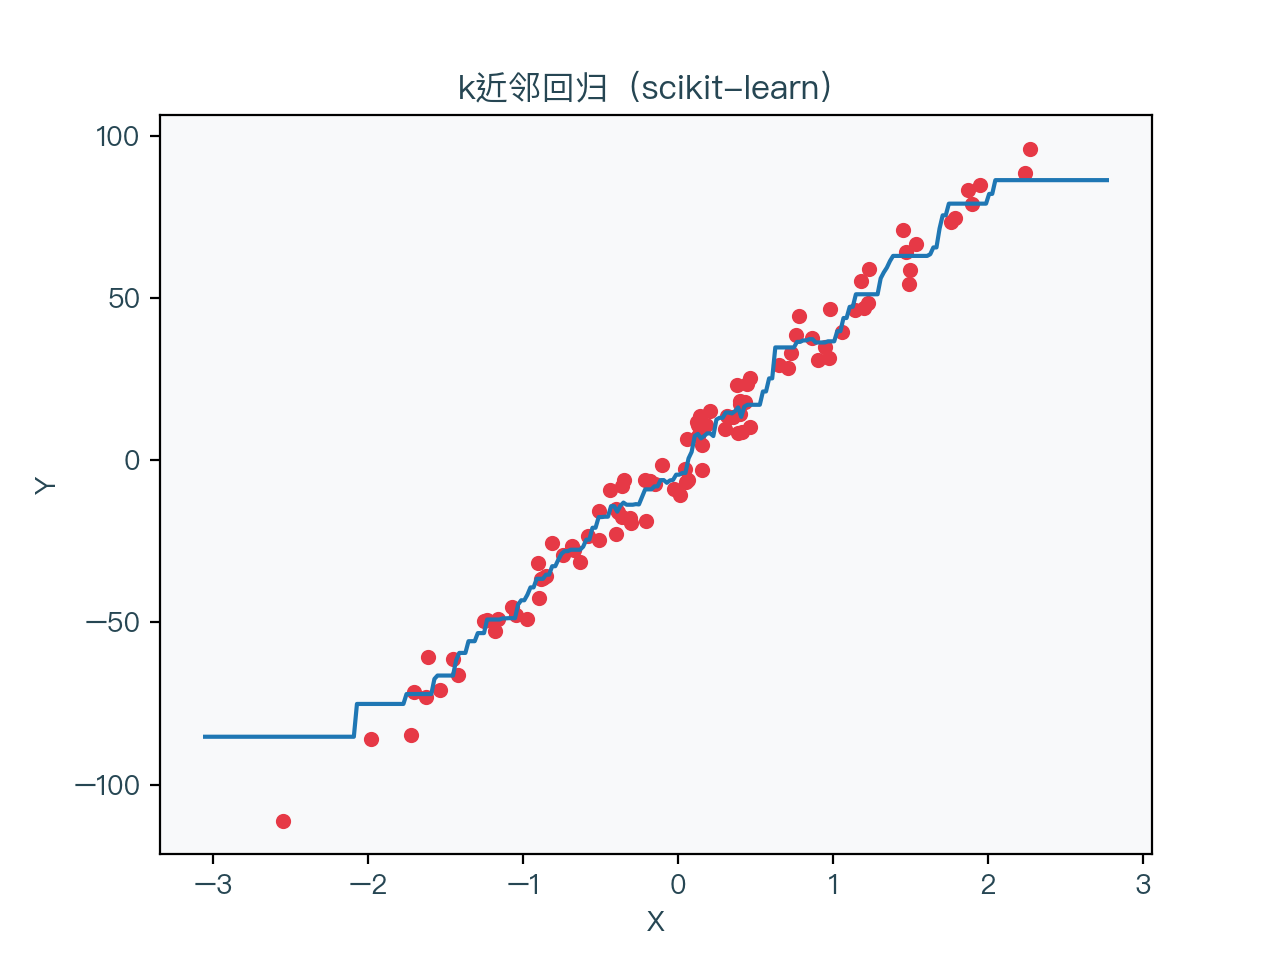

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

%matplotlib notebook

plt.rcParams['font.sans-serif'] = ['PingFang HK']  # 选择一个本地的支持中文的字体
fig, ax = plt.subplots()
ax.set_facecolor('#f8f9fa')

x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
xx = np.arange(x_min, x_max, .02)
yy = reg.predict(np.c_[xx.ravel()])

plt.scatter(X, y, c='#e63946', marker='o', s=20)
plt.plot(xx, yy)

ax.set_title('k近邻回归（scikit-learn）', color='#264653')
ax.set_xlabel('X', color='#264653')
ax.set_ylabel('Y', color='#264653')
ax.tick_params(labelcolor='#264653')
plt.show()